<a href="https://colab.research.google.com/github/sanikak96/Data-Science-Projects/blob/master/CNNMusicGenreClassificationAugmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 2: Music Genre Classification using Mel Spectrograms - Augmented Data

A spectrogram is a visualization of the frequency spectrum of a signal, where the frequency spectrum of a signal is the frequency range that is contained by the signal. A mel spectrogram is a spectrogram converted to the mel scale.
Since humans do not perceive sound linearly, mel scale is used to make the inputs to the neurons more natural.The Mel Scale is a logarithmic transformation of a signal’s frequency.

Mel spectrograms have been used as inputs since a long time. [Choi et al. (2016)](https://arxiv.org/abs/1606.00298) show that mel spectrograms are superior to the other features used while audio classification like STFT and MFCCs.

I am going to experiment using Mel spectograms for music genre classification.

After using CNN on the 999 spectrograms of the original dataset, the CNN performs just a little better than 50%. This is not a very good accuracy. In order to improve it, I am going to run the same model on augmented data.

### Importing Libraries

In [1]:
! pip install pydub

#Importing libraries for Audio Preprocessing 
import librosa 
import librosa.display
import skimage
import numpy as np
import pandas as pd
import imageio
import json
import IPython.display as ipd
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil

#Importing modules needed for modeling
import tensorflow as tf
from tensorflow.python import eager #To get the number of gpus
from tensorflow.python.client import device_lib 
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, load_model

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot,plot_model
#from keras.optimizers import adam_v2
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import random

### Mounting google drive
Note: The paths can be modified by importing kaggle API key and downloading the data. However, since creating and storing spectrograms of augmented data would take a long time, I am going to store them on my drive and use them from there for training the CNN model defined in experiment 1.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Data Preprocessing

In [ ]:
os.makedirs('/content/spectrograms3sec')

### Getting a list of genre and splitting the audio files
The audio files are split into 3 sec files and stored as per the original format of the dataset.

In [ ]:
data_dir='/content/gdrive/My Drive/DL_Project/Data/genres_original'
list_files=os.listdir(data_dir)
genres=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    genres.append(file)
genres

['blues',
 'metal',
 'classical',
 'hiphop',
 'country',
 'reggae',
 'jazz',
 'pop',
 'rock',
 'disco']

In [ ]:
for g in genres:
  path_audio = os.path.join('/content/audioSplit',f'{g}')
  os.makedirs(path_audio)
  
  path = os.path.join('/content/gdrive/My Drive/DL_Project/spectrogramsSplit/',f'{g}')
  os. makedirs(path)


In [ ]:
# Delete Faulty File
exists = os.path.isfile("/content/gdrive/MyDrive/DL_Project/Data/genres_original/jazz/jazz.00054.wav")

if exists:
  os.remove('/content/gdrive/MyDrive/DL_Project/Data/genres_original/jazz/jazz.00054.wav')
  print("Deleted the faulty file.")
else:
  print("File Deleted Already!")

File Deleted Already!


In [ ]:
from pydub import AudioSegment
newSong = 'newSong'
i = 0
for genre in genres:
  j=0
  print(f"{genre}")
  for filename in os.listdir(os.path.join('/content/gdrive/MyDrive/DL_Project/Data/genres_original/',f"{genre}")):

    song  =  os.path.join(f'/content/gdrive/MyDrive/DL_Project/Data/genres_original/{genre}',f'{filename}')
    j = j+1
    for w in range(0,10):
      i = i+1
      start = 3*(w)*1000
      end = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[start:end]
      new.export(f'/content/audioSplit/{genre}/{genre+str(j)+str(w)}.wav', format="wav")

blues
metal
classical
hiphop
country
reggae
jazz
pop
rock
disco


In [ ]:
!zip -r /content/audioSplit.zip /content/audioSplit

### Creating Spectrograms for each audio file

In [ ]:
for genre in genres:
  
  j = 0
  print("Saving audio files for genre:",genre)
  for filename in os.listdir(os.path.join('/content/audioSplit',f"{genre}")):
    song  =  os.path.join(f'/content/audioSplit/{genre}',f'{filename}')
    j = j+1
    
    y,sr = librosa.load(song,duration=3)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'/content/gdrive/My Drive/DL_Project/spectrogramsSplit/{genre}/{genre+str(j)}.png')
    print(filename, "saved")


### Checking the number of files -- optional
The cell can be run to check if all the files are stored at a given path

In [ ]:
import os
APP_FOLDER = '/content/gdrive/My Drive/DL_Project/spectrogramsSplit/classical/'
totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

### Splitting the Spectrogram Dataset into Training, Test and Validation data

The data is present in folders and hence I am using the `splitfolders` library to create these datasets. The dataset has a total of 999 files. I have kept 80% data for model training, 1% for validation and 1% for testing.

In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
os.makedirs('/content/gdrive/My Drive/DL_Project/Data/spectogram_data_3sec/')

In [ ]:
splitfolders.ratio('/content/gdrive/My Drive/DL_Project/spectrogramsSplit/', output="/content/gdrive/My Drive/DL_Project/Data/spectogram_data_3sec", seed=0, ratio=(0.6, 0.2,0.2)) 

Copying files: 8990 files [05:09, 29.07 files/s]


### Scaling the spectrograms

`ImageDataGenerator` is used to generate batches of tensor image data with real-time data augmentation. We use it to scale the images. 

Keras’ ImageDataGenerator class provide three different functions to loads the image dataset in memory and generates batches of augmented data. These three functions are:
- flow()
- flow_from_directory()
- flow_from_dataframe()

The `flow_from_directory()` function is used since the folder contains sub-directories, each containing images of respective classes.

In [12]:
train_dir = "/content/gdrive/My Drive/DL_Project/Data/spectogram_data_3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=32)

validation_dir = "/content/gdrive/My Drive/DL_Project/Data/spectogram_data_3sec/val/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=32)


Found 5394 images belonging to 10 classes.
Found 1798 images belonging to 10 classes.


## Classification Model
Creating and running a CNN classifier on the augmented data

In [ ]:
def GenreModel(input_shape = (288,432,4),classes=10):
  np.random.seed(9)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=9))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model


In [ ]:
model = GenreModel(input_shape=(288,432,4),classes=10)
opt = tf.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 16)      1

In [ ]:
history = model.fit(train_generator,epochs=40,validation_data=validation_generator)

Epoch 1/40
81/81 [==============================] - 855s 10s/step - loss: 1.9303 - acc: 0.2727 - val_loss: 2.3523 - val_acc: 0.1118
Epoch 2/40
81/81 [==============================] - 43s 527ms/step - loss: 1.5343 - acc: 0.4526 - val_loss: 2.4300 - val_acc: 0.2202
Epoch 3/40
81/81 [==============================] - 43s 528ms/step - loss: 1.3813 - acc: 0.4951 - val_loss: 2.0059 - val_acc: 0.2603
Epoch 4/40
81/81 [==============================] - 43s 530ms/step - loss: 1.2410 - acc: 0.5599 - val_loss: 1.6525 - val_acc: 0.4483
Epoch 5/40
81/81 [==============================] - 43s 530ms/step - loss: 1.1374 - acc: 0.5923 - val_loss: 1.5465 - val_acc: 0.4399
Epoch 6/40
81/81 [==============================] - 43s 531ms/step - loss: 1.0608 - acc: 0.6317 - val_loss: 1.3184 - val_acc: 0.5545
Epoch 7/40
81/81 [==============================] - 43s 534ms/step - loss: 0.9809 - acc: 0.6641 - val_loss: 1.2566 - val_acc: 0.5584
Epoch 8/40
81/81 [==============================] - 43s 529ms/step - l

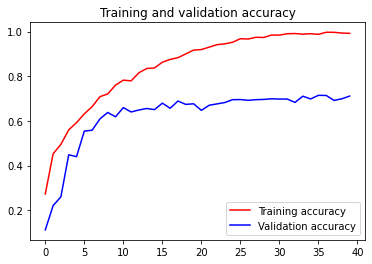

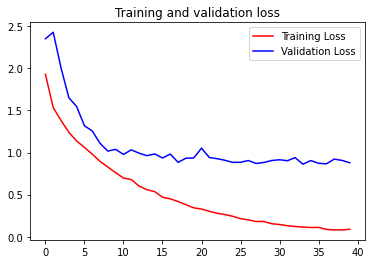

In [ ]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_performance(history)

### Save the trained model for future use
I have saved the model in .h5 format

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# save model
model.save('genreModel.h5')
print('Model Saved!')
 
import h5py 
# load model
savedModel=load_model('genreModel.h5')
savedModel.summary()

Model Saved!
Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 21

### Plotting the model graph for better visualization

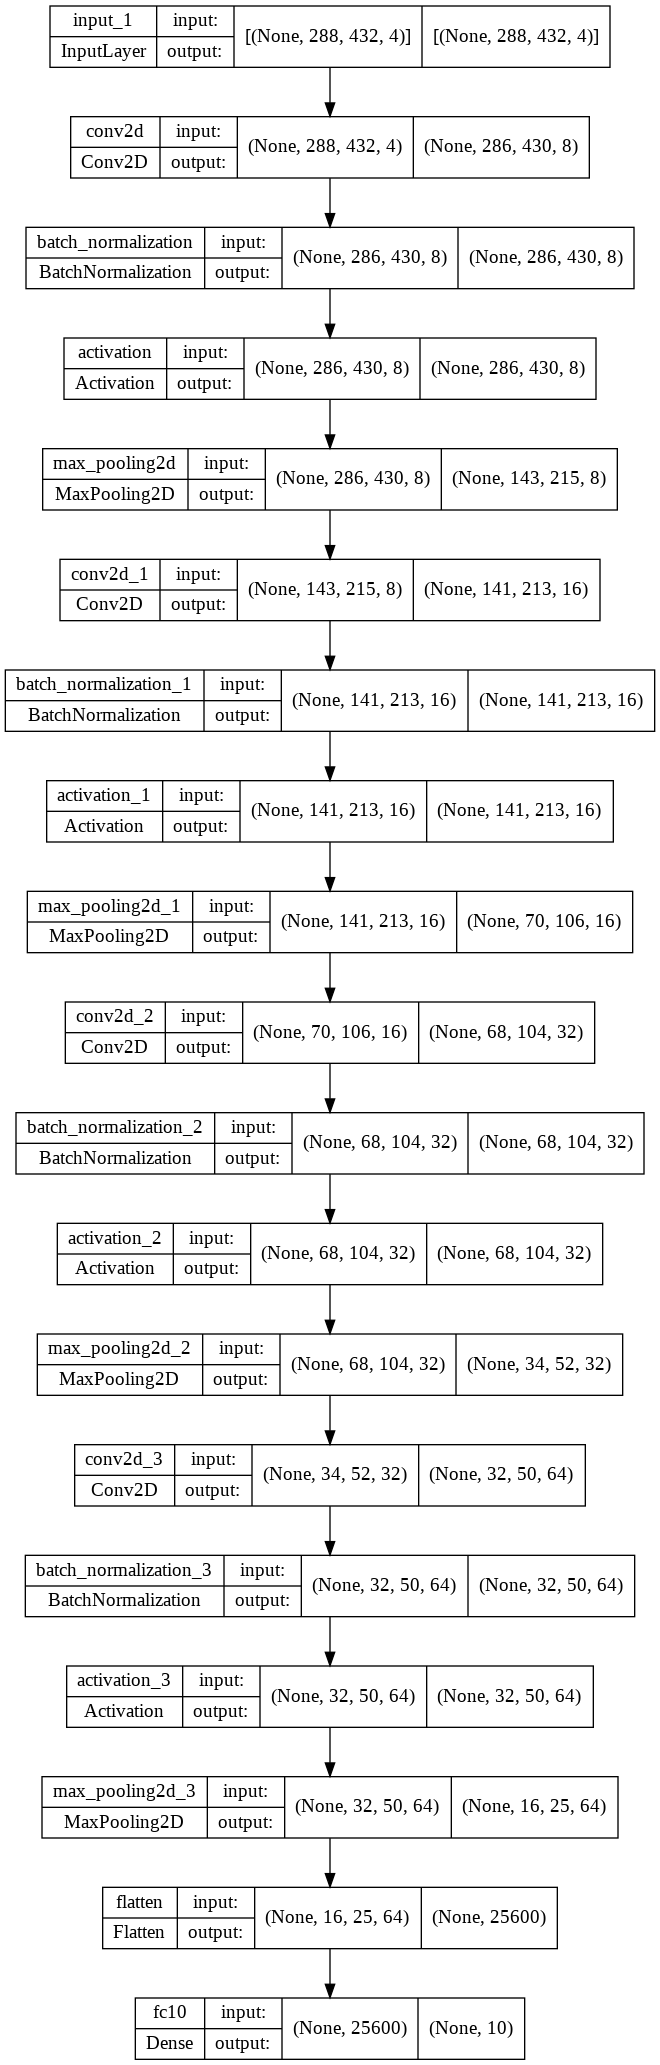

In [ ]:
dot_img_file = 'genreModel.png'
tf.keras.utils.plot_model(savedModel, to_file=dot_img_file, show_shapes=True)

### Create a test generator for testing

In [4]:
test_dir = "/content/gdrive/My Drive/DL_Project/Data/spectogram_data_3sec/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=32)


Found 1798 images belonging to 10 classes.


### Predict for test data
We can predict per sample. I have created a dataframe from all the predictions. I have extracted the original label from the song file names.
These can be compared to get better idea about the results. 

In [6]:
savedModel.evaluate_generator(test_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


57/57 [==============================] - 288s 5s/step - loss: 0.8618 - acc: 0.7158


[0.8617639541625977, 0.7157953381538391]

The first value here represents loss and the second shows accuracy of the model. The model has an accuracy of 71.5% on test data. 

In [22]:
test_generator.reset()
files=test_generator.filenames
class_dict=test_generator.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key   # dictionary of the form class index: class name
predictions = savedModel.predict(test_generator)

In [23]:
file_name =[]
class_pred = []
probability_pred = []
for i, p in enumerate(predictions):
    index=np.argmax(p)
    klass=rev_dict[index]    
    prob=p[index]
    file_name.append(files[i])
    class_pred.append(klass)
    probability_pred.append(prob)
    #print('for file ', files[i], ' predicted class is ', klass,' with probability ',prob)


In [24]:
zipped = list(zip(file_name, class_pred, probability_pred))
prediction_df = pd.DataFrame(zipped, columns=['Filename', 'Predicted_Label', 'Prediction_Probability'])
prediction_df

,Filename,Predicted_Label,Prediction_Probability
0,blues/blues10.png,jazz,0.998700
1,blues/blues110.png,hiphop,0.997227
2,blues/blues112.png,metal,0.608364
3,blues/blues128.png,classical,0.999922
4,blues/blues133.png,reggae,0.961586
...,...,...,...
1793,rock/rock973.png,country,0.974009
1794,rock/rock985.png,pop,0.939982
1795,rock/rock987.png,blues,0.512033
1796,rock/rock989.png,hiphop,0.706390


In [25]:
prediction_df.to_csv("prediction_df_augmented_spectrograms",index=False)
# Splitting the song name to get original label
prediction_df["Labels_original"] = prediction_df["Filename"].str.split("/").str[0]

In [26]:
prediction_df[prediction_df["Predicted_Label"]==prediction_df["Labels_original"]]

,Filename,Predicted_Label,Prediction_Probability,Labels_original
10,blues/blues166.png,blues,0.387889,blues
24,blues/blues226.png,blues,0.369613,blues
25,blues/blues227.png,blues,0.488743,blues
36,blues/blues286.png,blues,0.826118,blues
54,blues/blues358.png,blues,0.411567,blues
...,...,...,...,...
1760,rock/rock861.png,rock,0.939767,rock
1761,rock/rock863.png,rock,0.747791,rock
1765,rock/rock877.png,rock,0.765405,rock
1772,rock/rock900.png,rock,0.447979,rock


### Results:

- The training loss decreases quite smoothly after each iteration where as the validation loss decreases sharply but then the decrease is lesser
- The accuracy score is used as a metric to evaluate the algorithm
- The training accuracy of 99.9% is achieved at the end of last iteration (40th epoch).
- The corresponding validation accuracy is 71.13%
- The model performs better on augmented data than the original version and the accuracy for test data is 71.57%

### Conclusion: 

It was necessary to augment the data to achieve better performance. Mel spectrograms are a useful feature of music genre classification.